In [1]:
from keras.src.callbacks import EarlyStopping

from database_io import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy import optimize as optim


print(np.__version__)


1.26.4


In [29]:
# path of databases (must exist)
db_path = "db/"

# filenames of databases (this must be sqlite3 databases)
train_fname = "surf17BigBoy_train.db"
validation_fname = "surf17_validation.db"
test_fname = "surf17_test.db"

dim_syndr = 8 # Ancilla Qubts
dim_fsyndr = 4 # distance 3 + 1 for final output parity
n_steps_net1 = 20 #
n_steps_net2 = 3 # distance

data = DatabaseIO(dim_syndr, dim_fsyndr, n_steps_net1, n_steps_net2)

In [30]:
try:
    data.close_databases()
except:
    pass
data.load_data(db_path + train_fname, db_path + validation_fname, db_path + test_fname)



batch_size = 64
n_batches_train = 1000
n_batches_validation = 100



class DecoderSequence(Sequence):
    def __init__(self, data, batch_size, n_batches, data_type):
        self.data = data
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.data_type = data_type
        self.on_epoch_end()

    def __len__(self):
        return self.n_batches

    def __getitem__(self, idx):
        # return the idx-th batch captured at epoch start
        return self.epoch_batches[idx]

    def on_epoch_end(self):
        """Called automatically by Keras at the end of each epoch."""
        gen = self.data.gen_batches(
            self.batch_size,
            self.n_batches,
            data_type=self.data_type
        )

        self.epoch_batches = []
        for _ in range(self.n_batches):
            batch_x1, batch_x2, batch_fx, batch_l1, batch_l2, batch_y = next(gen)

            # Wrap into Keras multi-input format
            inputs = (batch_x1, batch_x2, batch_fx) #, batch_l1, batch_l2)
            outputs = batch_y
            self.epoch_batches.append((inputs, outputs))

train_seq = DecoderSequence(
    data,
    batch_size=batch_size,
    n_batches=n_batches_train,
    data_type='training'
)

val_seq = DecoderSequence(
    data,
    batch_size=batch_size,
    n_batches=n_batches_validation,
    data_type='validation'
)


loaded databases and checked exclusiveness training, validation, and test keys
N_training=1000000, N_validaiton=10000, N_test=50000.


In [31]:
# DEFINING THE MODEL
x1 = Input(shape=(None, dim_syndr), name="x1_full")
x2 = Input(shape=(n_steps_net2, dim_syndr), name="x2_recent")
fx = Input(shape=(dim_fsyndr,), name="final_increment")

x1_masked = layers.Masking(mask_value=0.0)(x1)

dropout_rate = 0.2
layer_width = 128

# Network 1 (full syndrome history)
h1 = layers.LSTM(layer_width, activation="tanh", return_sequences=True, kernel_regularizer=keras.regularizers.l2(1e-5))(x1_masked)
h1 = layers.Dropout(dropout_rate)(h1)
h1 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5))(h1)
h1 = layers.Dropout(dropout_rate)(h1)
p1 = layers.Dense(layer_width, activation="relu", name="p1", kernel_regularizer=keras.regularizers.l2(1e-5))(h1)
p1 = layers.Dropout(dropout_rate)(p1)
p1 = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(1e-5), name="p1_prob")(p1)


# Network 2 (recent syndrome + final increment)
h2 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5), return_sequences=True)(x2)
h2 = layers.Dropout(dropout_rate)(h2)
h2 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5))(h2)
h2 = layers.Dropout(dropout_rate)(h2)

p2 = layers.Concatenate()([h2, fx])
p2 = layers.Dense(layer_width, activation="relu", name="p2", kernel_regularizer=keras.regularizers.l2(1e-5))(p2)
p2 = layers.Dropout(dropout_rate)(p2)
p2 = layers.Dense(1, activation="sigmoid", name="p2_prob", kernel_regularizer=keras.regularizers.l2(1e-5))(p2)


# Final combination p = probabilistic sum
p_final = layers.Lambda(lambda x: x[0]*(1-x[1]) + x[1]*(1-x[0]))([p1, p2]) # XOR Gate

model = Model(inputs=[x1, x2, fx], outputs=p_final)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x1_full             │ (None, None, 8)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None, 8)   │          0 │ x1_full[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x2_recent           │ (None, 3, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, None, 8)   │          0 │ x1_full[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, None)      │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 3, 128)    │     70,144 │ x2_recent[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, None, 128) │     70,144 │ masking_4[0][0],  │
│                     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 3, 128)    │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, None, 128) │          0 │ lstm_16[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 128)       │    131,584 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 128)       │    131,584 │ dropout_24[0][0], │
│                     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128)       │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_increment     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ lstm_17[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 132)       │          0 │ dropout_28[0][0], │
│ (Concatenate)       │                   │            │ final_increment[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1 (Dense)          │ (None, 128)       │     16,512 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2 (Dense)          │ (None, 128)       │     17,024 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ p1[0][0]          │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128)       │          0 │ p2[0][0]        

 Total params: 437,250 (1.67 MB)

 Trainable params: 437,250 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# COMPILING AND TRAINING THE MODEL
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

num_epochs = 1000

checkpoint = ModelCheckpoint(
    'best_model.keras',        # file path to save the model
    monitor='val_accuracy',    # metric to monitor
    verbose=1,                 # prints message when saving
    save_best_only=True,       # only save if improved
    mode='max'                 # 'min' for loss, 'max' for accuracy
)

early_stop = EarlyStopping(
    monitor='val_accuracy',    # use validation accuracy to monitor
    patience=50,               # stop after n epochs with no improvement
    min_delta=1e-4,            # threshold for minimum change over epochs -> "no imporovement"
    restore_best_weights=True, # keeps weights from the best epoch
    verbose=1
)


results = model.fit(
    train_seq,
    steps_per_epoch=n_batches_train,
    epochs=num_epochs,
    verbose=1,
    validation_data=val_seq,
    validation_steps=n_batches_validation,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/1000
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6503 - loss: 0.5604
Epoch 1: val_accuracy improved from None to 0.52906, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7490 - loss: 0.4441 - val_accuracy: 0.5291 - val_loss: 0.7242
Epoch 2/1000
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8957 - loss: 0.2630
Epoch 2: val_accuracy improved from 0.52906 to 0.60406, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.8980 - loss: 0.2517 - val_accuracy: 0.6041 - val_loss: 0.6815
Epoch 3/1000
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9045 - loss: 0.2278
Epoch 3: val_accuracy improved from 0.60406 to 0.61859, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9065 - loss: 0.2238 - val_accuracy: 0.6186 - val_loss: 0.6349
Epoch 4/1000
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9132 - loss: 0.2077
Epoch 4: 

Text(0.5, 1.0, '128 neuron Model')

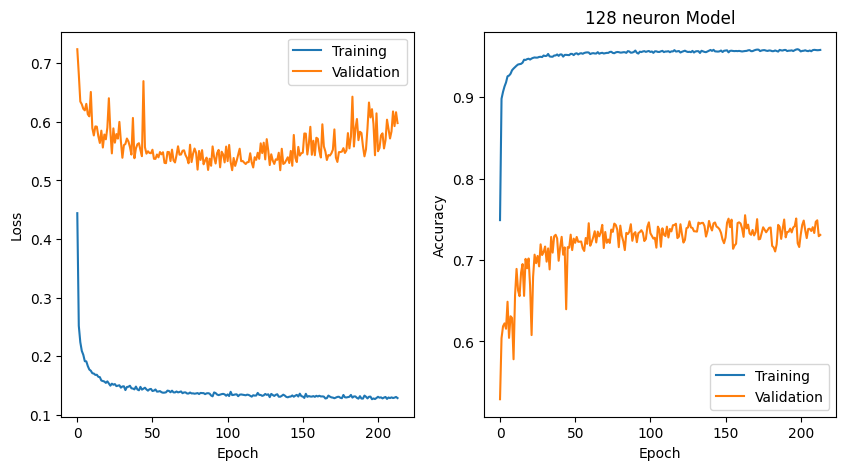

In [33]:
from plotting import plot_model_history, make_roc
plot_model_history(results)
plt.title("128 neuron Model")


In [34]:
# stat calculation taken from original code

def decay(x, p_logical, x0):
  """ This functions is used to make a exponential fit to the fidelity
      curves """
  return (1 + (1 - 2 * p_logical)**(x - x0)) / 2.

def calc_stats(data, n_sampling=5000, x0_max=10, verbose=False):
    """ calculates the logical error rate and error bars """

    # since it is possible that the batch does not contain fidelities
    # for all steps, hence we need a list with all steps for which
    # predictions excist (we call it 'steps')
    steps, data_nonzero = [], []
    fids, rs_means_l, plogs_bs = [], [], []

    # in the following we assume that the first step is s = 1
    for s in range(1, len(data) + 1):
        dat = data[s - 1]
        if len(dat) != 0:
            # non-trivial data points
            steps.append(s)
            data_nonzero.append(dat)
            # fidelities
            fids.append(np.mean(dat))

    # fit decay curve to the non-tivial data
    popt, pcov = optim.curve_fit(
        decay, steps, fids, bounds=((0.0001, 0.0001), (.1, x0_max)))
    plog, x0 = popt[0], popt[1]
    if x0 > 0.99 * x0_max:
        print("WARNING, x0 is larger than", x0_max,
            "the fitting algorithm fails")
    if plog > .09:
        print("WARNING, plog is larger than 9%, the fitting algorithm fails")



    res_dict = {'steps': steps, 'fids': fids, 'plog': plog, 'x0': x0, 'plog_error': np.sqrt(pcov[0,0])}
    if verbose:
        print("logical error rate:", round(plog * 100, 5), "%")
        print("x0 offset", round(x0, 3))

    return res_dict


In [35]:


num_samples = int(10000)


batch = None
for gen in data.gen_batches(num_samples, 1, data_type='test'):
    batch = gen
x1, x2, fx, l1, _, y_actual = batch
y_prob = model.predict((x1,x2,fx))


7188/7188 ━━━━━━━━━━━━━━━━━━━━ 452s 63ms/step


# Figure 3

logical error rate: 0.41534 %
x0 offset 4.867


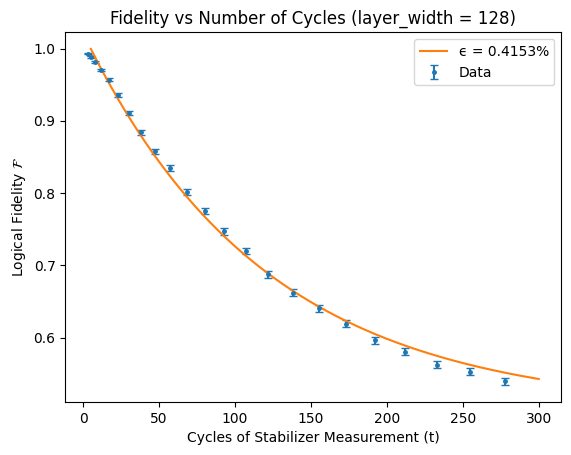

Overall Accuracy: 0.7737695652173913


In [36]:
y_preds_bool = np.empty_like(y_actual)
l_arr = np.array(range(501))
errors = np.zeros_like(l_arr)
samples = np.zeros_like(l_arr)
for idx in range(y_actual.size):
    samples[l1[idx]] += 1
    y_pred = y_prob[idx] > 0.5
    y_preds_bool[idx] = y_pred
    if (y_pred != y_actual[idx]) :
        errors[l1[idx]] += 1

comp_list = np.equal(y_preds_bool, y_actual).astype('float')
comparison = []
for n in range(max(l1)):
    comparison.append([])
for n in range(len(comp_list)):
    idx = l1[n] - 1
    comparison[idx].append(comp_list[n])
stats_dict = calc_stats(comparison, n_sampling=5000, x0_max=10, verbose=True)
fidelity = np.divide(samples - errors, samples, out=np.zeros_like(errors, dtype=float), where=(samples != 0)).astype(float)

x, y, yerr = [], [], []
for idx in range(len(fidelity)):
    if (fidelity[idx] != 0):
        x.append(l_arr[idx])
        y.append(fidelity[idx])

        # binomial error calculation (bootstraps 3sigma)
        se = np.sqrt(fidelity[idx] * (1 - fidelity[idx]) / samples[idx])
        yerr.append(se)


plog = stats_dict['plog']
x0 = stats_dict['x0']

t = np.linspace(5, 300, 10000)
F = (1 + (1 - 2 * plog)**(t - x0)) / 2

plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, label='Data', markersize=2.5)
plt.title(f"Fidelity vs Number of Cycles (layer_width = {layer_width})")
plt.plot(t, F, linestyle = "-", label = f"ϵ = {round(plog*100, 4)}%")

plt.legend()
plt.ylabel(r"Logical Fidelity $\mathcal{F}$")
plt.xlabel("Cycles of Stabilizer Measurement (t)")
plt.grid(0)
plt.savefig(f"Figure3_N={num_samples}neurons{layer_width}.png", dpi=300)
plt.show()

print(f"Overall Accuracy: {1 - np.sum(errors) / np.sum(samples)}")

'# Figure 4 Data

In [37]:
Figure4_lst = []
Figure4_error_lst =[]
fy_lst = [0, 0.5, 1, 1.5, 2]

for fy in fy_lst:
    test_fname = f"surf17fy{fy}_test.db"



    batch = None
    for gen in data.gen_batches(num_samples, 1, data_type='test'):
        batch = gen
    x1, x2, fx, l1, _, y_actual = batch
    y_prob = model.predict((x1,x2,fx))

    print(f"fy = {fy}")

    y_preds_bool = np.empty_like(y_actual)
    l_arr = np.array(range(501))
    errors = np.zeros_like(l_arr)
    samples = np.zeros_like(l_arr)
    for idx in range(y_actual.size):
        samples[l1[idx]] += 1
        y_pred = y_prob[idx] > 0.5
        y_preds_bool[idx] = y_pred
        if (y_pred != y_actual[idx]) :
            errors[l1[idx]] += 1

    comp_list = np.equal(y_preds_bool, y_actual).astype('float')
    comparison = []
    for n in range(max(l1)):
        comparison.append([])
    for n in range(len(comp_list)):
        idx = l1[n] - 1
        comparison[idx].append(comp_list[n])
    stats_dict = calc_stats(comparison, n_sampling=5000, x0_max=10, verbose=True)

    Figure4_lst.append(stats_dict['plog'])
    Figure4_error_lst.append(stats_dict['plog_error'])

print(Figure4_lst)






7188/7188 ━━━━━━━━━━━━━━━━━━━━ 443s 62ms/step
fy = 0
logical error rate: 0.40717 %
x0 offset 4.608
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 460s 64ms/step
fy = 0.5
logical error rate: 0.41802 %
x0 offset 4.604
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 440s 61ms/step
fy = 1
logical error rate: 0.41221 %
x0 offset 4.781
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 444s 62ms/step
fy = 1.5
logical error rate: 0.4019 %
x0 offset 3.638
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 460s 64ms/step
fy = 2
logical error rate: 0.41681 %
x0 offset 4.216
[0.00407165392459029, 0.004180180607059566, 0.004122079331258514, 0.0040189632162393055, 0.0041681221586509195]


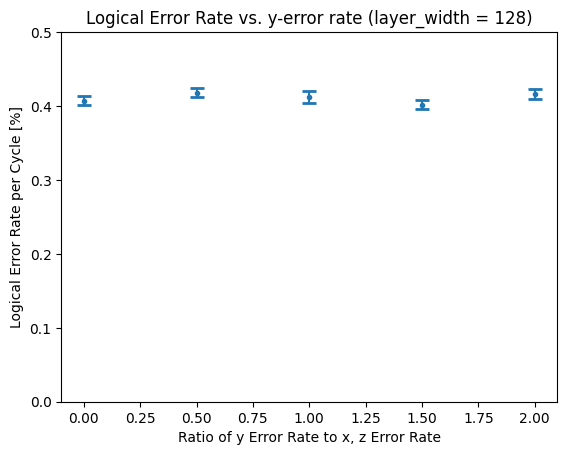

In [38]:
Figure4_lst_p = np.array(Figure4_lst)*100
Figure4_error_lst_p = np.array(Figure4_error_lst)*100

plt.errorbar(fy_lst, Figure4_lst_p, yerr=Figure4_error_lst_p, fmt='.', capsize=5, capthick=2)
plt.title(f"Logical Error Rate vs. y-error rate (layer_width = {layer_width})")
plt.xlabel("Ratio of y Error Rate to x, z Error Rate")
plt.ylabel(f"Logical Error Rate per Cycle [%]")
plt.ylim(0, 0.5)
plt.savefig(f"Figure4_N={num_samples}neurons{layer_width}.png", dpi=300)
plt.show()